This notebook characterizes the dependence of sequence replay on specific model parameter combinations.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as cprod
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import smln


N_SEEDS = 10
MAX_SEED = 1000
DTCN_WDW = .1
TRJ_CUTOFF = .75
NTRJ_CUTOFF = .5

# model
M_PARAMS = {
    # Exc. PC membrane
    'T_M_PC': 0.05, 'E_L_PC': -0.068, 'V_TH_PC': -0.036, 'V_R_PC': -0.068, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1000,
    'W_PC_PC': 0.03, 'L_PC_PC': 0.083, 'W_MIN_PC_PC': 0.001,
    
    # "Place-tuned" PC inputs
    'R_MAX': 20, 'L_PL': .15,
    'W_PC_PL': 0.02, 'S_PC_PL': 0,
    
    # Inh. membrane
    'T_M_INH': 0.009, 'E_L_INH': -0.058, 'V_TH_INH': -0.036, 'V_R_INH': -0.058, 'T_R_INH': 0.002,  # unused (presently)
    
    # Inh. architecture
    'N_INH': 100,
    
    # gating inputs
    'W_PC_G': 0.008216, 'S_PC_G': 0,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.005, 
    
    # Gating input firing rates for traj and replay epochs
    'R_G': 125, 
    
    # potentiation
    'SGM_MAX': 2, 'B_SGM': 1, 'R_SGM': 10
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": 2, "BOX_W": 2, "X_TRG": 1, "Y_TRG": -0.75,
    
    'SPD': 0.2, 'TRJ': [(-1, .75), (0, .75), (0, -.75), (1, -.75)],
    
    'TRG': [
        {'T': 0.5, 'A': 0.008, 'R': 0.4, 'D': 0.003, 'X': 1, 'Y': -0.75},
    ],
    
    "schedule": {"D_SMLN": .8},
    
    "metrics": {
        "WDW": 0.1, "MIN_SCALE_TRJ": 1.25,
        "MIN_FRAC_SPK_TRJ": 0.75, "MAX_AVG_SPK_CT_TRJ": 3, "TRJ_NON_TRJ_SPK_RATIO": 1.5,
    }
}

# Define fadeout, blowup, and replay, detection functions

In [2]:
def detect_rsp_type(rslt, m_params, s_params):
    # get mask over trj and non-trj PCs
    mask_pc = rslt.ntwk.types_rcr == 'PC'
    
    sgm_cutoff = .5 * (1 + m_params['SGM_MAX'])
    
    trj_mask = (rslt.ntwk.sgm * mask_pc.astype(float)) > sgm_cutoff
    ntrj_mask = (~trj_mask) & mask_pc
    
    # get t-mask for detection wdw
    start = s_params['TRG'][0]['T']
    end = start + DTCN_WDW
    t_mask = (start <= rslt.ts) & (rslt.ts < end)
    
    # get spk cts in for trj/non-trj cells during detection wdw
    spks_trj = rslt.spks[t_mask][:, trj_mask]
    spks_ntrj = rslt.spks[t_mask][:, ntrj_mask]
    
    # get frac of trj/non-trj cells that spikes
    p_spk_trj = np.mean(spks_trj.sum(0) > 0)
    p_spk_ntrj = np.mean(spks_ntrj.sum(0) > 0)
    
    # categorize event
    if p_spk_trj < TRJ_CUTOFF:
        return 'fadeout'
    elif p_spk_ntrj >= NTRJ_CUTOFF:
        return 'blowup'
    else:
        return 'replay'

# Test

## Fadeout

Running smln...
Smln complete.
RSP TYPE:  fadeout


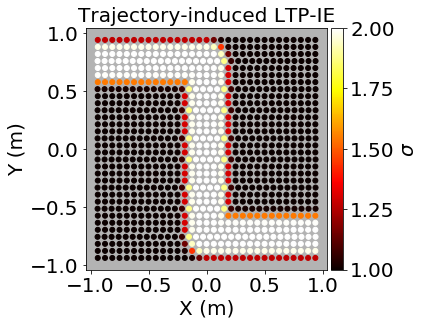

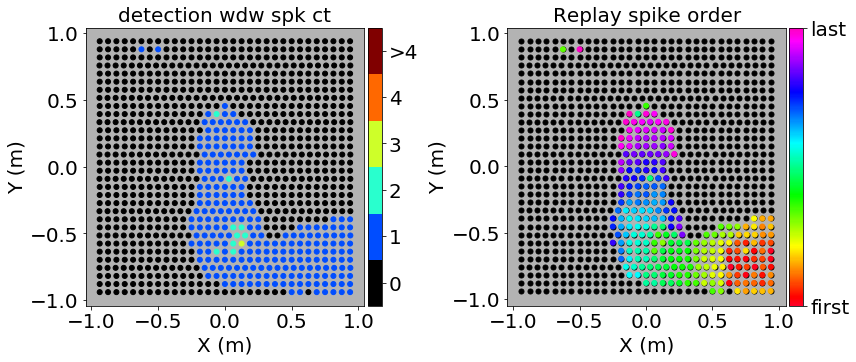

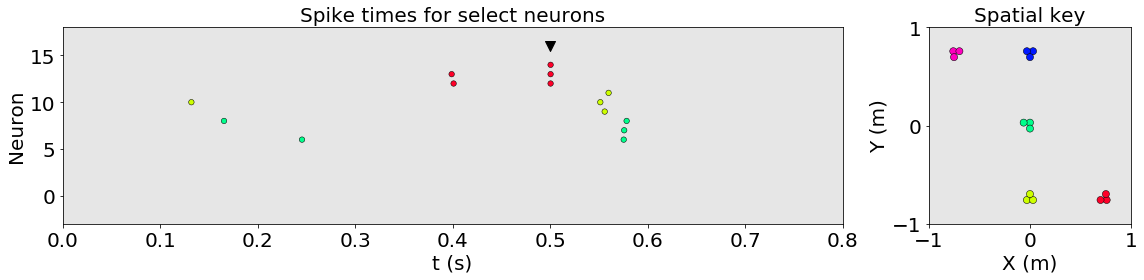

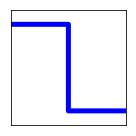

In [3]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .028
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

## Blowup

Running smln...
Smln complete.
RSP TYPE:  blowup


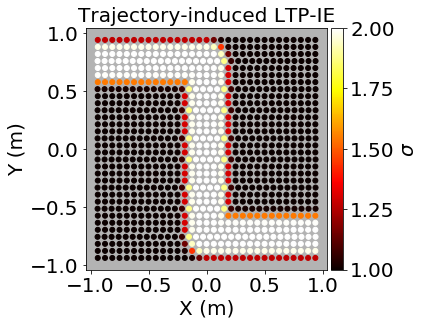

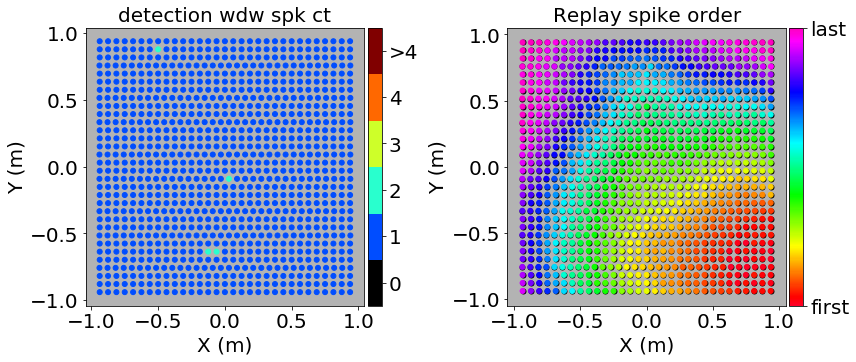

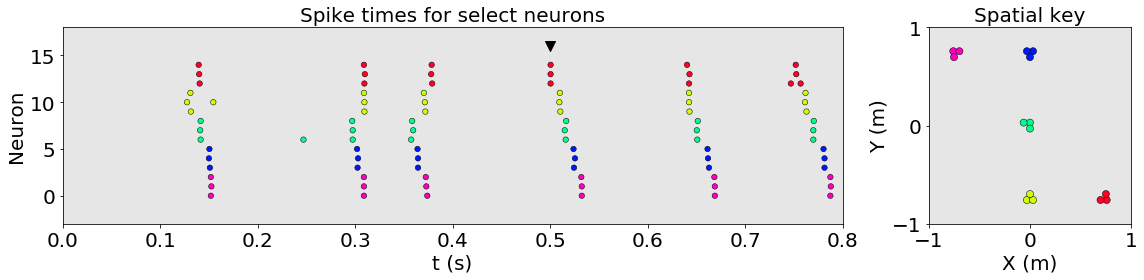

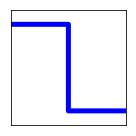

In [4]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    m_params['W_PC_PC'] = .05
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

## Replay

Running smln...
Smln complete.
RSP TYPE:  replay


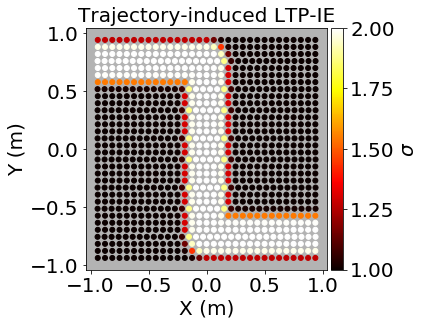

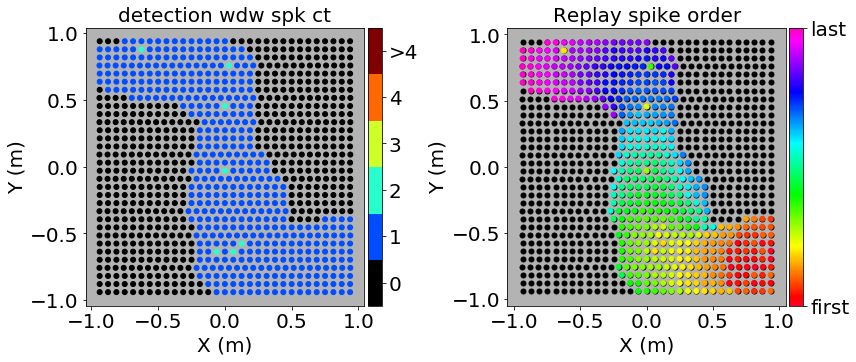

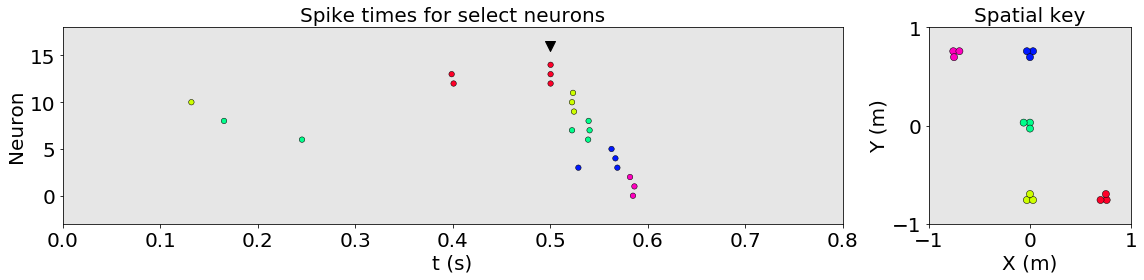

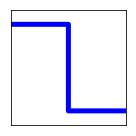

In [5]:
def test():
    from replay import plot

    m_params = copy(M_PARAMS)
    s_params = copy(S_PARAMS)
    s_params['RNG_SEED'] = 14  # pick demo showing example spontaneous replay
    s_params['TRJ'] = [(-1, .75), (0, .75), (0, -.75), (1, -.75)]

    print('Running smln...')
    rslt = smln.run(m_params, s_params)
    print('Smln complete.')

    # make plots
    plot.heat_maps(rslt, cmap='gist_rainbow');

    plot.raster(
        rslt,
        xys=[
        (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
        ],
        colors=np.linspace(1, 0, 5),
        cmap='gist_rainbow',
        nearest=3,
        epoch='replay',
        trg_plt=[(16, 'v'), (-1.5, '^'), (16, 'v'), (-1.5, '^')],
        y_lim=(-3, 18),
        y_ticks=np.linspace(0, 15, 4),
        title='Spike times for select neurons',
    )

    # plot trj
    trj = smln.build_trj(s_params)
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), tight_layout=True)
    ax.plot(trj['x'], trj['y'], lw=5, color='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    set_font_size(ax, 20);

    print('RSP TYPE: ', detect_rsp_type(rslt, m_params, s_params))

test()

# Plot saved results

# Run param sweep

In [ ]:
SAVE_FILE = 'replay_param_sweep_XXX_YYY_NNN.csv'
PRINT_EVERY = 50


# define params to vary and ranges
COL_0, VALS_0 = 'XXX', np.linspace(1, 3, 61)
COL_1, VALS_1 = 'YYY', np.linspace(80, 180, 61)

assert COL_0 in M_PARAMS
assert COL_1 in M_PARAMS

DF_COLS = ['SMLN_ID', 'N_REPLAY', COL_0, COL_1, 'N_FADEOUT', 'N_BLOWUP'] + \
    sum([['RSP_{}'.format(ctr), 'SEED_{}'.format(ctr)] for ctr in range(N_SEEDS)], [])


np.random.seed(0)

# write save file header
with open(SAVE_FILE, 'w') as f:
    # fixed params
    f.write('{}\n{}\n\n'.format(M_PARAMS, S_PARAMS))
    # col names
    f.write('{}\n'.format(','.join(DF_COLS)))

n_trials = len(VALS_0) * len(VALS_1)
    
# loop over params
for tr_ctr, (val_0, val_1) in enumerate(cprod(VALS_0, VALS_1)):
    
    if tr_ctr % PRINT_EVERY == 0:
        print('\nRunning trial {}/{}'.format(tr_ctr+1, n_trials))
    sys.stdout.write('.')
    
    save_dict = {'SMLN_ID': tr_ctr, 'N_SEEDS': N_SEEDS, COL_0: val_0, COL_1: val_1}
    
    # set variable model params
    m_params = copy(M_PARAMS)
    m_params[COL_0] = val_0
    m_params[COL_1] = val_1

    # make s_params copy
    s_params = copy(S_PARAMS)

    # loop over RNG seeds
    n_fadeout = 0
    n_blowup = 0
    n_replay = 0
    
    for seed_ctr in range(N_SEEDS):

        s_params['SEED'] = np.random.randint(MAX_SEED)
        
        rslt = smln.run(m_params, s_params)
        
        rsp_type = detect_rsp_type(rslt, m_params, s_params)
        
        if rsp_type == 'fadeout':
            n_fadeout += 1
        elif rsp_type == 'blowup':
            n_blowup += 1
        elif rsp_type == 'replay':
            n_replay += 1
            
        save_dict['RSP_{}'.format(seed_ctr)] = rsp_type
        save_dict['SEED_{}'.format(seed_ctr)] = s_params['SEED']
    
    save_dict['N_REPLAY'] = n_replay
    save_dict['N_FADEOUT'] = n_fadeout
    save_dict['N_BLOWUP'] = n_blowup
    
    
    df = pd.DataFrame(data={k: [v] for k, v in save_dict.items()}, columns=DF_COLS)
    
    with open(SAVE_FILE, 'a') as f:
        df.to_csv(f, index=False, header=False)